In [1]:
import pysam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def calculate_read_depth(bam_file):
    """
    Calculate read depths from the BAM file for each position.
    """
    samfile = pysam.AlignmentFile(bam_file, "rb")
    positions = []
    depths = []
    for pileupcolumn in samfile.pileup():
        positions.append(pileupcolumn.pos)
        depths.append(pileupcolumn.n)
    samfile.close()

    return pd.DataFrame({"position": positions, 'depth': depths})

In [3]:
def mean_depth(df, window_size=1000):
    """
    Calculate mean depth in the given window. 
    """
    df['window'] = df['position'] // window_size
    df = df.groupby(['window']).agg({'position': 'mean', 'depth': 'mean'}).reset_index()
    return df

In [4]:
tumor_bam_file = "tumor_analysis/tu_part_sorted.bam"
wildtype_bam_file = "wildtype_analysis/wt_part_sorted.bam"

In [5]:
# Calulate read depths for each position.
tumor_df = calculate_read_depth(tumor_bam_file)
wildtype_df = calculate_read_depth(wildtype_bam_file)

# Calculate meand read depth for windows of size 1000.
wildtype_df = mean_depth(wildtype_df, 1000)
tumor_df = mean_depth(tumor_df, 1000)

In [6]:
ratio_df = pd.merge(wildtype_df, tumor_df, on=['position'], suffixes=('_wt', '_tumor'))

# Calculate the log2 ratio between tumor depth and wild-type depth
ratio_df['log2_ratio'] = np.log2(ratio_df['depth_tumor'] / ratio_df['depth_wt'])

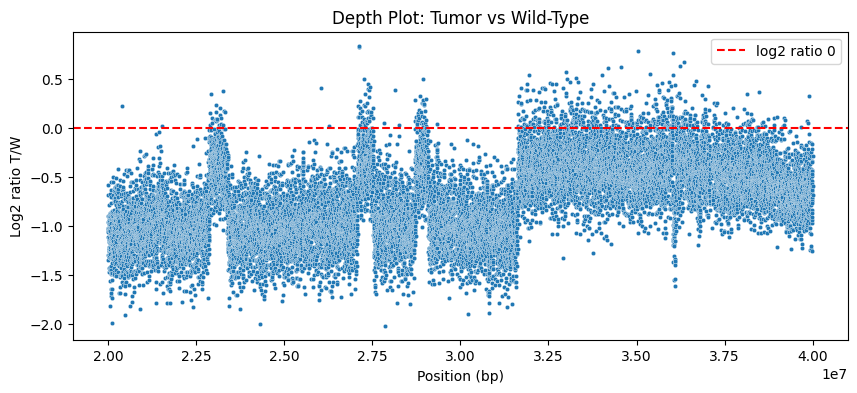

In [7]:
# Depth plot:
plt.figure(figsize=(10, 4))

sns.scatterplot(x='position', y='log2_ratio', data=ratio_df, s=10)
# show horizontal line at log2 ratio 0
plt.axhline(y=0, color='r', linestyle='--', label='log2 ratio 0')
plt.title('Depth Plot: Tumor vs Wild-Type')
plt.xlabel('Position (bp)')
plt.ylabel('Log2 ratio T/W')
plt.legend()
plt.show()

Based on the depth plot, we can see that the tumor sample has lower coverage throughout the whole selected area.
The coverage of the tumor sample is roughly half of the size of the wild-type sample in the positions 2.0e7 to 3.2e7.
Coverage of the tumor sample in the rest of the selected area is aroud 0.4 in log2 ratio. Also, there are 3 peaks 
in the first part with similar coverage to the second part. We can also see slightly decreasing coverage in interval 
3.75e7 to 4.0e7. 

The fact that the tumor sample has lower mean coverage throughout the selected area might be cause by some error 
during the analysis. Tumor sample might be for example downsampled in comparison to the wild-type, which results
in the lowe coverage in comparision to the wild-type. Because of the fact that the tumor sample is downsampled 
throughout the whole genome, we cannot reliably say where possible up/down-sampled variants might be. They might 
be in the peaks but we cannot be sure.